In [3]:
import json
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import random
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay

In [4]:
con = sqlite3.connect(r"../laliga.sqlite")
# Change date format (2029 -> 1929)
df = pd.read_sql_query("SELECT * FROM Matches", con)

# Data formatting:
# We split the "date" column into the corresponding columns, and specify the correct formatting.
# This way we avoid the year 29 or higher to be mistaken by 2029 (error with to_datetime function).
df[["month", "day", "year"]] = df["date"].str.split("/", 2, expand = True)
df["year"] = df["year"].apply(lambda x: f"19{x}" if int(x) >= 23 else f"20{x}")
df['date'] = pd.to_datetime(df[['day', 'month', 'year']]).dt.strftime('%d/%m/%Y') 

# We also change the formatting of the time to be in 24h format
df['time'] = df['time'].apply(lambda x: datetime.strftime(datetime.strptime(x, "%I:%M %p"), "%H:%M") if type(x) == str else x)

df[["home_goals", "away_goals"]] = df["score"].str.split(":", expand=True).astype(float)
df2=df.dropna(subset = "score")
df2["goal diff"] = (df2["home_goals"]  - df2["away_goals"])
df2["results"] = np.where(df2["goal diff"] > 0, "1", np.where(df2["goal diff"] < 0, "2", "X"))
df2['home_win'] = df['home_goals'] > df['away_goals']
df2.head()

,season,division,matchday,date,time,home_team,away_team,score,month,day,year,home_goals,away_goals,goal diff,results,home_win
0,1928-1929,1,1,10/02/1929,None,Arenas Club,Athletic Madrid,2:3,2,10,1929,2.0,3.0,-1.0,2,False
1,1928-1929,1,1,10/02/1929,None,Espanyol,Real Unión,3:2,2,10,1929,3.0,2.0,1.0,1,True
2,1928-1929,1,1,10/02/1929,None,Real Madrid,Catalunya,5:0,2,10,1929,5.0,0.0,5.0,1,True
3,1928-1929,1,1,10/02/1929,None,Donostia,Athletic,1:1,2,10,1929,1.0,1.0,0.0,X,False
4,1928-1929,1,1,12/02/1929,None,Racing,Barcelona,0:2,2,12,1929,0.0,2.0,-2.0,2,False


In [5]:
def parse_seasons(value):
    if value == "all":
        return "all"
    seasons = []
    for chunk in value.split(","):
        if ":" in chunk:
            try:
                start, end = map(int, chunk.split(":"))
                assert start < end
            except Exception:
                print("error")
            for i in range(start, end):
                seasons.append(f"{i}-{i+1}")
        else:
            try:
                start, end = map(int, chunk.split("-"))
                assert start == end - 1
            except Exception:
                print("error")
            seasons.append(chunk)
    return seasons

In [44]:
train_seasons = parse_seasons("2010:2022")
x_train = df2[df2["season"].isin(train_seasons)]
x_train

,season,division,matchday,date,time,home_team,away_team,score,month,day,year,home_goals,away_goals,goal diff,results,home_win
21878,2010-2011,1,1,28/08/2010,18:00,Hércules CF,Athletic,0:1,8,28,2010,0.0,1.0,-1.0,2,False
21879,2010-2011,1,1,28/08/2010,20:00,Málaga CF,Valencia,1:3,8,28,2010,1.0,3.0,-2.0,2,False
21880,2010-2011,1,1,28/08/2010,22:00,Levante,Sevilla FC,1:4,8,28,2010,1.0,4.0,-3.0,2,False
21881,2010-2011,1,1,29/08/2010,17:00,Espanyol,Getafe,3:1,8,29,2010,3.0,1.0,2.0,1,True
21882,2010-2011,1,1,29/08/2010,17:00,Real Sociedad,Villarreal,1:0,8,29,2010,1.0,0.0,1.0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48585,2021-2022,2,3,28/08/2021,22:00,Ponferradina,Girona,2:1,8,28,2021,2.0,1.0,1.0,1,True
48586,2021-2022,2,3,29/08/2021,17:00,SD Amorebieta,UD Almería,2:1,8,29,2021,2.0,1.0,1.0,1,True
48587,2021-2022,2,3,29/08/2021,19:30,CD Lugo,Real Valladolid,0:2,8,29,2021,0.0,2.0,-2.0,2,False
48588,2021-2022,2,3,29/08/2021,19:30,Real Sociedad B,CF Fuenlabrada,0:0,8,29,2021,0.0,0.0,0.0,X,False


In [126]:
with open("../abs_rankings.json", "r") as ranking_input:
    abs_rankings = json.load(ranking_input)

results_dic = {}

def inv_conv(lst):
    return [ -i for i in lst ]

def direct_confrontations_and_ranking(Team1, Team2, df):
    ranking_team1 = []
    ranking_team2 = []
    df3 = df.loc[((df["home_team"] == Team2) & (df["away_team"] == Team1)) | ((df["home_team"] == Team1) & (df["away_team"] == Team2))]
    df3["Winner"] = np.where(df3["goal diff"] > 0, df3.home_team.values, np.where(df3["goal diff"] < 0, df3.away_team.values, "tie"))
    direct_confrontation_count = df3["Winner"].value_counts()
    if Team1 not in direct_confrontation_count and Team2 not in direct_confrontation_count:
        team1_scoring = 0
        team2_scoring = 0
    elif Team1 not in direct_confrontation_count or Team2 not in direct_confrontation_count:
        if Team1 not in direct_confrontation_count:
            team1_scoring = 0
            team2_scoring = direct_confrontation_count[Team2]
        else:
            team1_scoring = direct_confrontation_count[Team1]
            team2_scoring = 0
    else:
        team1_scoring = direct_confrontation_count[Team1]
        team2_scoring = direct_confrontation_count[Team2]
    
    seasons = df3["season"].unique()
    for season in seasons:
        try:
            ranking_team1.append(abs_rankings[season][Team1])
        except KeyError:
            pass
        try:
            ranking_team2.append(abs_rankings[season][Team2])
        except KeyError:
            pass
    avg_ranking_team1 = round(np.average(ranking_team1), 3)
    avg_ranking_team2 = round(np.average(ranking_team2), 3)
    return [team1_scoring - team2_scoring, avg_ranking_team1 - avg_ranking_team2]


def dic_saver(team1, team2, df):
    subdic_direct = {}
    subdic_inv = {}
    direct_conf_res = direct_confrontations_and_ranking(team1, team2, df)
    subdic_direct[team2] = direct_conf_res
    subdic_inv[team1] = inv_conv(direct_conf_res)
    results_dic[team1] = subdic_direct
    results_dic[team2] = subdic_inv

In [127]:
x_train["win_diff"] = 0
x_train["rank_diff"] = 0
for index, row in x_train.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]
    try: 
        exists = results_dic[home_team][away_team]
    except KeyError:
        dic_saver(home_team, away_team, x_train)
    # results_dic [team1][team2] = [win1-win2, rank1-rank2]
    x_train.at[row.name,"win_diff"] = results_dic[home_team][away_team][0]
    x_train.at[row.name,"rank_diff"] = results_dic[home_team][away_team][1]

In [128]:
x_train

,season,division,matchday,date,time,home_team,away_team,score,month,day,year,home_goals,away_goals,goal diff,results,home_win,win_diff,rank_diff
21878,2010-2011,1,1,28/08/2010,18:00,Hércules CF,Athletic,0:1,8,28,2010,0.0,1.0,-1.0,2,False,-2,13.000
21879,2010-2011,1,1,28/08/2010,20:00,Málaga CF,Valencia,1:3,8,28,2010,1.0,3.0,-2.0,2,False,-6,3.750
21880,2010-2011,1,1,28/08/2010,22:00,Levante,Sevilla FC,1:4,8,28,2010,1.0,4.0,-3.0,2,False,-5,6.900
21881,2010-2011,1,1,29/08/2010,17:00,Espanyol,Getafe,3:1,8,29,2010,3.0,1.0,2.0,1,True,1,0.444
21882,2010-2011,1,1,29/08/2010,17:00,Real Sociedad,Villarreal,1:0,8,29,2010,1.0,0.0,1.0,1,True,-6,1.700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48585,2021-2022,2,3,28/08/2021,22:00,Ponferradina,Girona,2:1,8,28,2021,2.0,1.0,1.0,1,True,-5,5.000
48586,2021-2022,2,3,29/08/2021,17:00,SD Amorebieta,UD Almería,2:1,8,29,2021,2.0,1.0,1.0,1,True,1,10.000
48587,2021-2022,2,3,29/08/2021,19:30,CD Lugo,Real Valladolid,0:2,8,29,2021,0.0,2.0,-2.0,2,False,1,6.600
48588,2021-2022,2,3,29/08/2021,19:30,Real Sociedad B,CF Fuenlabrada,0:0,8,29,2021,0.0,0.0,0.0,X,False,0,-2.000


In [159]:
# Model testing
col_names = ["win_diff", "rank_diff"]
X = x_train[col_names]
y = x_train.results
x_train_true = X.iloc[8200:9200,:]
y_train_true = y.iloc[8200:9200]
x_test_true = X.iloc[9200:,:]
y_test_true = y.iloc[9200:]

cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

model_results = {}
for algorithm in ["auto", "ball_tree", "kd_tree", "brute"]:
    for n_neighbors in [5, 10, 15, 20, 30, 40, 50]:
        # we create an instance of Neighbours Classifier and fit the data.
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights="distance", algorithm=algorithm)
        clf.fit(x_train_true, y_train_true)
        model_results[f"{weight}, {algorithm}, {n_neighbors}"] = clf.score(x_test_true, y_test_true)

sorted_models = dict(sorted(model_results.items(), key=lambda item: item[1], reverse = True))
print(sorted_models)

{'distance, auto, 30': 0.5887096774193549, 'distance, ball_tree, 30': 0.5887096774193549, 'distance, kd_tree, 30': 0.5887096774193549, 'distance, brute, 30': 0.5887096774193549, 'distance, auto, 50': 0.5806451612903226, 'distance, ball_tree, 40': 0.5806451612903226, 'distance, ball_tree, 50': 0.5806451612903226, 'distance, kd_tree, 50': 0.5806451612903226, 'distance, brute, 40': 0.5806451612903226, 'distance, brute, 50': 0.5806451612903226, 'distance, auto, 15': 0.5725806451612904, 'distance, auto, 20': 0.5725806451612904, 'distance, auto, 40': 0.5725806451612904, 'distance, ball_tree, 15': 0.5725806451612904, 'distance, ball_tree, 20': 0.5725806451612904, 'distance, kd_tree, 15': 0.5725806451612904, 'distance, kd_tree, 20': 0.5725806451612904, 'distance, kd_tree, 40': 0.5725806451612904, 'distance, brute, 20': 0.5725806451612904, 'distance, brute, 15': 0.5645161290322581, 'distance, brute, 10': 0.5564516129032258, 'distance, auto, 10': 0.5483870967741935, 'distance, ball_tree, 10': 0.

In [157]:
type(clf)

SyntaxError: invalid syntax (3270424319.py, line 1)

Text(0.5, 1.0, "3-Class classification (k = 30, weights = 'distance')")

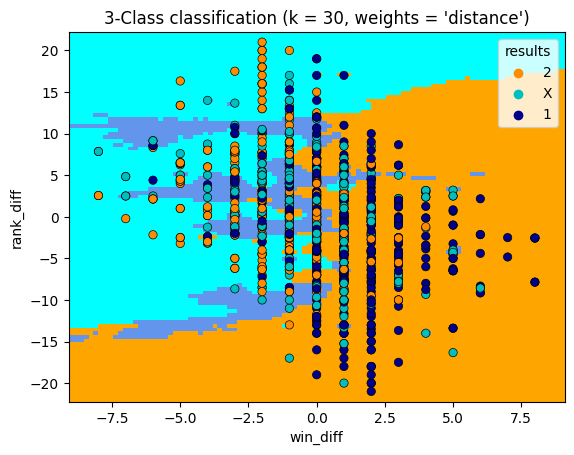

In [156]:
# Mirar que los colores coincidan!!!
n_neighbors = 30
weights = "distance"
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, algorithm="auto")
clf.fit(x_train_true, y_train_true)
_, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    clf,
    x_train_true,
    cmap=cmap_light,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel="win_diff",
    ylabel="rank_diff",
    shading="auto",
)

# Plot also the training points
sns.scatterplot(
    x=x_train_true["win_diff"],
    y=x_train_true["rank_diff"],
    hue=y_train_true,
    palette=cmap_bold,
    alpha=1.0,
    edgecolor="black",
)
plt.title(
    "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
)

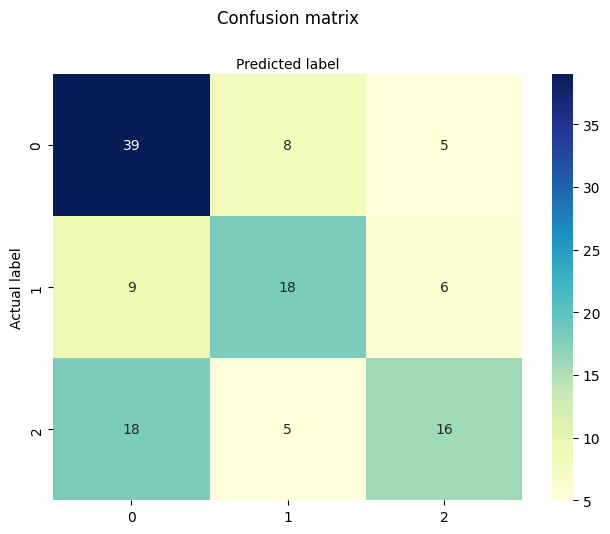

In [148]:
y_pred = clf.predict(x_test_true)

from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test_true, y_pred)
cnf_matrix
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.Text(0.5,257.44,'Predicted label');

# HERE: 2 variables

In [2]:
def avg_ranking_goals(team, df, gen_dic, res_dic):
    ranking = []
    net_goals = []
    seasons = df["season"].unique()
    for season in seasons:
        try:
            ranking.append(gen_dic["seasonal_data"][season][team][0])
        except KeyError:
            pass
        try:
            net_goals.append(gen_dic["seasonal_data"][season][team][1])
        except KeyError:
            pass
    avg_ranking = round(np.average(ranking), 3)
    avg_net_goals = round(np.average(net_goals), 3)
    res_dic[team] = [avg_ranking, avg_net_goals]

In [ ]:
train_seasons = parse_seasons("2010:2020")
train_df = df2[df2["season"].isin(train_seasons)]
train_df[["home_goals", "away_goals"]] = train_df["score"].str.split(":", expand=True).astype(float)
train_df["goal diff"] = (train_df["home_goals"] - train_df["away_goals"])
train_df["results"] = np.where(train_df["goal diff"] > 0, "1", np.where(train_df["goal diff"] < 0, "2", "X"))

dic_import_data = {}
with open("../feature_data.json", "r") as infile:
    dic_import_data = json.load(infile)

dic_feature_data = {}

train_df["rank_diff"] = 0
train_df["goal_diff"] = 0

for index, row in train_df.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]
    if home_team not in dic_feature_data:
        avg_ranking_goals(home_team, train_df, dic_import_data, dic_feature_data)
    if away_team not in dic_feature_data:
        avg_ranking_goals(away_team, train_df, dic_import_data, dic_feature_data)
    train_df.loc[row.name, "rank_diff"] = dic_feature_data[home_team][0] - dic_feature_data[away_team][0]
    train_df.loc[row.name, "goal_diff"] = dic_feature_data[home_team][1] - dic_feature_data[away_team][1]

with open("train_features.json", "w") as outfile:
    json.dump(dic_feature_data, outfile)

col_names = ["rank_diff", "goal_diff"]
x_train = train_df[col_names]
y_train = train_df.results

In [27]:
test_seasons = parse_seasons("2021:2022")
test_df = df2[df2["season"].isin(test_seasons)]

test_df[["home_goals", "away_goals"]] = test_df["score"].str.split(":", expand=True).astype(float)
test_df["goal diff"] = (test_df["home_goals"] - test_df["away_goals"])
test_df["results"] = np.where(test_df["goal diff"] > 0, "1", np.where(test_df["goal diff"] < 0, "2", "X"))

test_df["rank_diff"] = 0
test_df["goal_diff"] = 0


with open("train_features.json", "r") as infile:
    dic_feature_data = json.load(infile)

for index, row in test_df.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]
    if home_team not in dic_feature_data:
        avg_rank_home = 30
        avg_goals_home = -10
    else:
        avg_rank_home = dic_feature_data[home_team][0]
        avg_goals_home = dic_feature_data[home_team][1]
    
    if away_team not in dic_feature_data:
        avg_rank_away = 30
        avg_goals_away = -10
    else:
        avg_rank_away = dic_feature_data[away_team][0]
        avg_goals_away = dic_feature_data[away_team][1]

    test_df.loc[row.name, "rank_diff"] = avg_rank_home - avg_rank_away
    test_df.loc[row.name, "goal_diff"] = avg_goals_home - avg_goals_away

col_names = ["rank_diff", "goal_diff"]
x_test = test_df[col_names]
y_test = test_df.results

In [29]:
model_results = {}
for algorithm in ["auto", "ball_tree", "kd_tree", "brute"]:
    for n_neighbors in [5, 10, 15, 20, 30, 40, 50]:
        # we create an instance of Neighbours Classifier and fit the data.
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights="distance", algorithm=algorithm)
        clf.fit(x_train, y_train)
        model_results[f"{algorithm}, {n_neighbors}"] = clf.score(x_test, y_test)

sorted_models = dict(sorted(model_results.items(), key=lambda item: item[1], reverse = True))
print(sorted_models)

{'auto, 15': 0.5, 'auto, 20': 0.5, 'auto, 40': 0.5, 'auto, 50': 0.5, 'ball_tree, 15': 0.5, 'ball_tree, 40': 0.5, 'ball_tree, 50': 0.5, 'kd_tree, 15': 0.5, 'kd_tree, 20': 0.5, 'kd_tree, 40': 0.5, 'kd_tree, 50': 0.5, 'brute, 15': 0.5, 'brute, 20': 0.5, 'brute, 40': 0.5, 'brute, 50': 0.5, 'auto, 30': 0.4838709677419355, 'ball_tree, 20': 0.4838709677419355, 'ball_tree, 30': 0.4838709677419355, 'kd_tree, 30': 0.4838709677419355, 'brute, 30': 0.4838709677419355, 'auto, 10': 0.46774193548387094, 'ball_tree, 10': 0.46774193548387094, 'kd_tree, 10': 0.46774193548387094, 'brute, 10': 0.46774193548387094, 'auto, 5': 0.45161290322580644, 'ball_tree, 5': 0.45161290322580644, 'kd_tree, 5': 0.45161290322580644, 'brute, 5': 0.45161290322580644}


Text(0.5, 1.0, "3-Class classification (k = 30, weights = 'distance')")

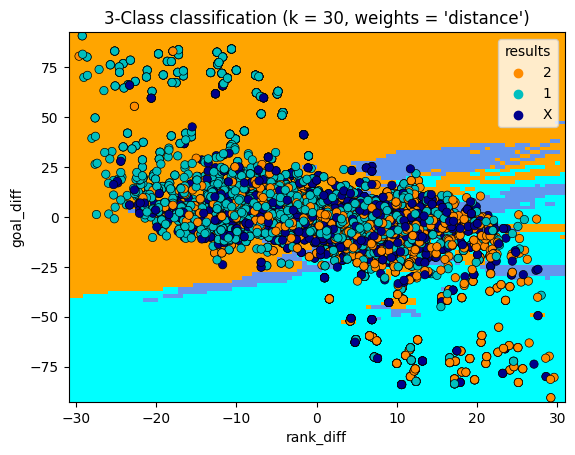

In [15]:
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

n_neighbors = 30
weights = "distance"
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, algorithm="auto")
clf.fit(x_train, y_train)
_, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    clf,
    x_train,
    cmap=cmap_light,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel="rank_diff",
    ylabel="goal_diff",
    shading="auto",
)

# Plot also the training points
sns.scatterplot(
    x=x_train["rank_diff"],
    y=x_train["goal_diff"],
    hue=y_train,
    palette=cmap_bold,
    alpha=1.0,
    edgecolor="black",
)
plt.title(
    "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
)

Precision: 0.5


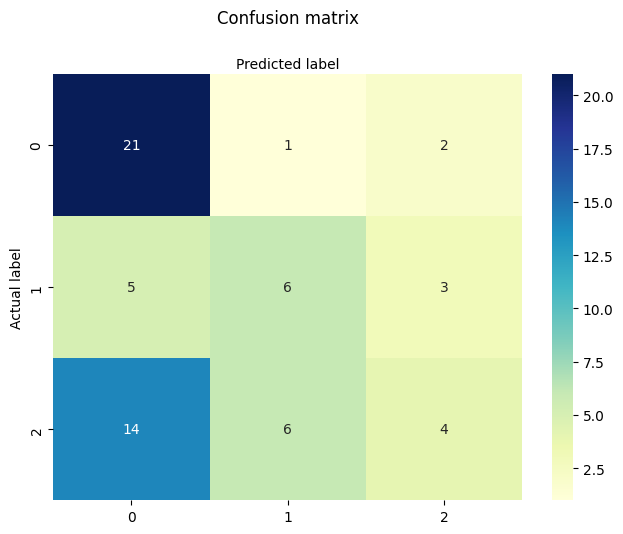

In [28]:
print(f"Precision: {clf.score(x_test, y_test)}")

y_pred = clf.predict(x_test)

from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.Text(0.5,257.44,'Predicted label');

# HERE: 4 variables (+ codificación de equipos)
Este es el que presenta mejores resultados, pero podéis usar los datos de arriba porque tiene el plot bonito ese.

In [45]:
try_train_df = train_df.copy(deep = True)
for index, row in try_train_df.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]
    try_train_df.loc[row.name, "home_team"] = dic_import_data["teams_codif"][home_team]
    try_train_df.loc[row.name, "away_team"] = dic_import_data["teams_codif"][away_team]

col_names = ["rank_diff", "goal_diff", "home_team", "away_team"]
x_train_1 = try_train_df[col_names]
y_train_1 = try_train_df.results

In [35]:
try_test_df = test_df.copy(deep = True)
for index, row in try_test_df.iterrows():
    home_team = row["home_team"]
    away_team = row["away_team"]
    try_test_df.loc[row.name, "home_team"] = dic_import_data["teams_codif"][home_team]
    try_test_df.loc[row.name, "away_team"] = dic_import_data["teams_codif"][away_team]

col_names = ["rank_diff", "goal_diff", "home_team", "away_team"]
x_test_1 = try_test_df[col_names]
y_test_1 = try_test_df.results

In [42]:
n_neighbors = 7
weights = "uniform"
algorithm = "ball_tree"
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, algorithm=algorithm)
clf.fit(x_train_1, y_train_1)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7)

In [43]:
print(f"Precision: {clf.score(x_test_1, y_test_1)}")

Precision: 0.5483870967741935


In [41]:
model_results = {}
for weight in ["uniform", "distance"]:
    for algorithm in ["auto", "ball_tree", "kd_tree", "brute"]:
        for n_neighbors in [5,6,7,8,9,10,11,12,13,14,15]:
            # we create an instance of Neighbours Classifier and fit the data.
            clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weight, algorithm=algorithm)
            clf.fit(x_train_1, y_train_1)
            model_results[f"{weight}, {algorithm}, {n_neighbors}"] = clf.score(x_test_1, y_test_1)

sorted_models = dict(sorted(model_results.items(), key=lambda item: item[1], reverse = True))
print(sorted_models)

{'uniform, ball_tree, 7': 0.5483870967741935, 'uniform, auto, 9': 0.532258064516129, 'uniform, ball_tree, 5': 0.532258064516129, 'uniform, ball_tree, 9': 0.532258064516129, 'uniform, kd_tree, 9': 0.532258064516129, 'uniform, brute, 6': 0.532258064516129, 'uniform, brute, 7': 0.532258064516129, 'distance, auto, 8': 0.532258064516129, 'distance, ball_tree, 8': 0.532258064516129, 'distance, ball_tree, 14': 0.532258064516129, 'distance, kd_tree, 8': 0.532258064516129, 'distance, brute, 7': 0.532258064516129, 'distance, brute, 8': 0.532258064516129, 'distance, brute, 9': 0.532258064516129, 'distance, brute, 10': 0.532258064516129, 'distance, brute, 11': 0.532258064516129, 'uniform, auto, 8': 0.5161290322580645, 'uniform, kd_tree, 8': 0.5161290322580645, 'distance, auto, 7': 0.5161290322580645, 'distance, auto, 9': 0.5161290322580645, 'distance, auto, 10': 0.5161290322580645, 'distance, auto, 11': 0.5161290322580645, 'distance, auto, 14': 0.5161290322580645, 'distance, ball_tree, 7': 0.51612